# Modelamiento
Tras explorar en detenimiento los datos y tener claras la preguntas de negocio se procede a generar un modelo (regresivo)

## Librerías

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## Importación de datos limpios y breve exploración

In [9]:
# df = pd.read_csv("Repositorio-Proyecto1\Ingeniería y análisis de datos\data_limpia.csv")
df = pd.read_csv("data_limpia.csv")
df.head()

,category,bathrooms,bedrooms,has_photo,price,price_display,price_type,square_feet,cityname,state,latitude,longitude,time
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,790,Monthly,101,Washington,DC,389057.0,-769861.0,1577359415
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,425,Monthly,106,Evansville,IN,379680.0,-876621.0,1577017063
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,1.39,Monthly,107,Arlington,VA,388910.0,-770816.0,1577359410
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,925,Monthly,116,Seattle,WA,476160.0,-1223275.0,1576667743
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,880,Monthly,125,Arlington,VA,388738.0,-771055.0,1577359401


In [10]:
df.describe()

,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000,9.917000e+03,9.917000e+03
mean,1.379097,1.743471,1486.055864,945.903499,376834.312796,-9.462911e+05,1.574871e+09
std,0.615455,0.941908,1078.397223,657.251935,55105.576026,1.581312e+05,3.771848e+06
min,1.000000,0.000000,200.000000,101.000000,213155.000000,-1.580221e+06,1.568744e+09
25%,1.000000,1.000000,949.000000,649.000000,336683.000000,-1.018587e+06,1.568781e+09
50%,1.000000,2.000000,1270.000000,802.000000,387555.000000,-9.365160e+05,1.577358e+09
75%,2.000000,2.000000,1695.000000,1100.000000,413712.000000,-8.187790e+05,1.577359e+09
max,8.500000,9.000000,52500.000000,40000.000000,615940.000000,-7.019160e+05,1.577362e+09


## Visualización y correlación

In [ ]:
Variables_Num = df.select_dtypes(include=['number']).columns.tolist()
Variables_NoNum = df.select_dtypes(exclude=['number']).columns.tolist()

['category', 'has_photo', 'price_display', 'price_type', 'cityname', 'state'] ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude', 'time']


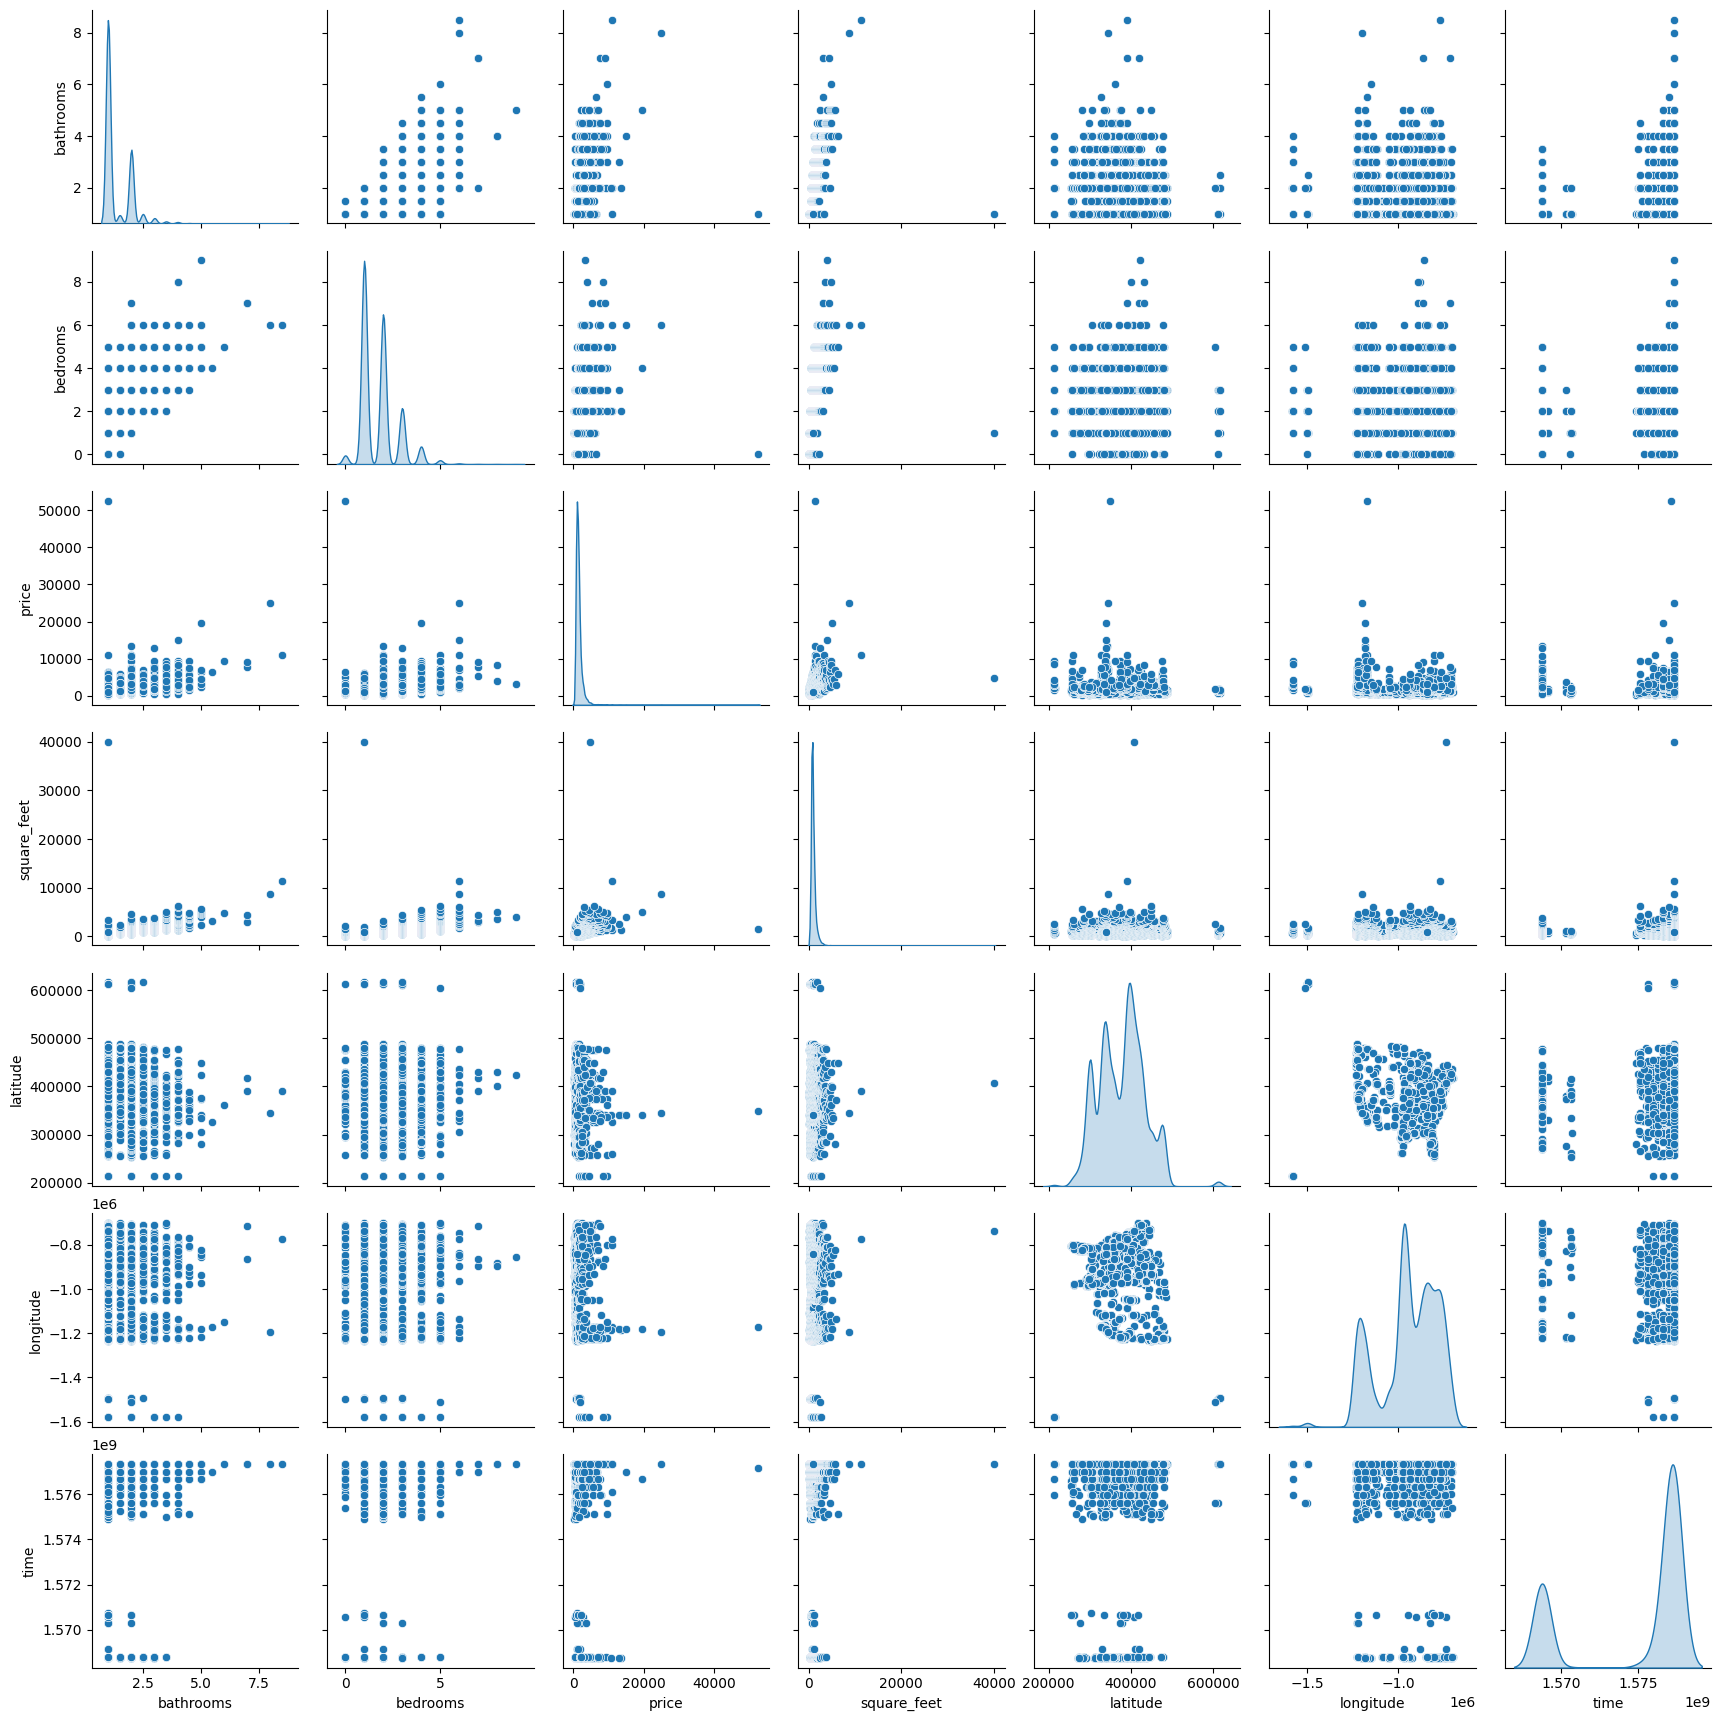

In [ ]:
sns.pairplot(df, diag_kind="kde")

### Variables numéricas exclusivamente

<Axes: >

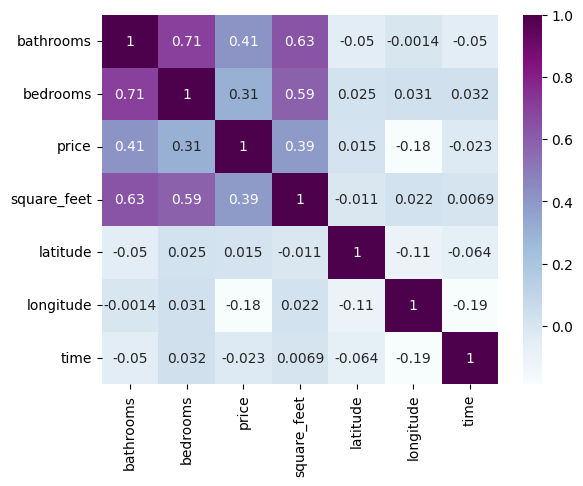

In [25]:
numeric_df = df.select_dtypes(include=['number']) 
sns.heatmap(numeric_df.corr(), cmap="BuPu", annot=True)

<Axes: >

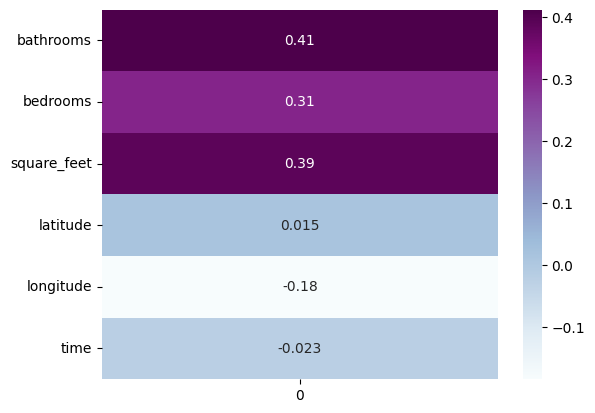

In [19]:
corr_price = numeric_df.drop(['price'], axis=1).corrwith(numeric_df['price'])
sns.heatmap(pd.DataFrame(corr_price), cmap="BuPu", annot=True)

La visualización de correlaciones con la variable de interés dan indicios como:
* _bathrooms_, _bedrooms_ y _squarefeet_ parecen ser las variables más indicadas para explicar el precio
* La influencia de _latitude_, _longitude_ y _time_ en principio parece no ser indispensable

In [39]:
Variables_Num.remove("time")
Variables_Num.remove("longitude")
Variables_Num.remove("latitude")

### Variables categóricas/no numéricas

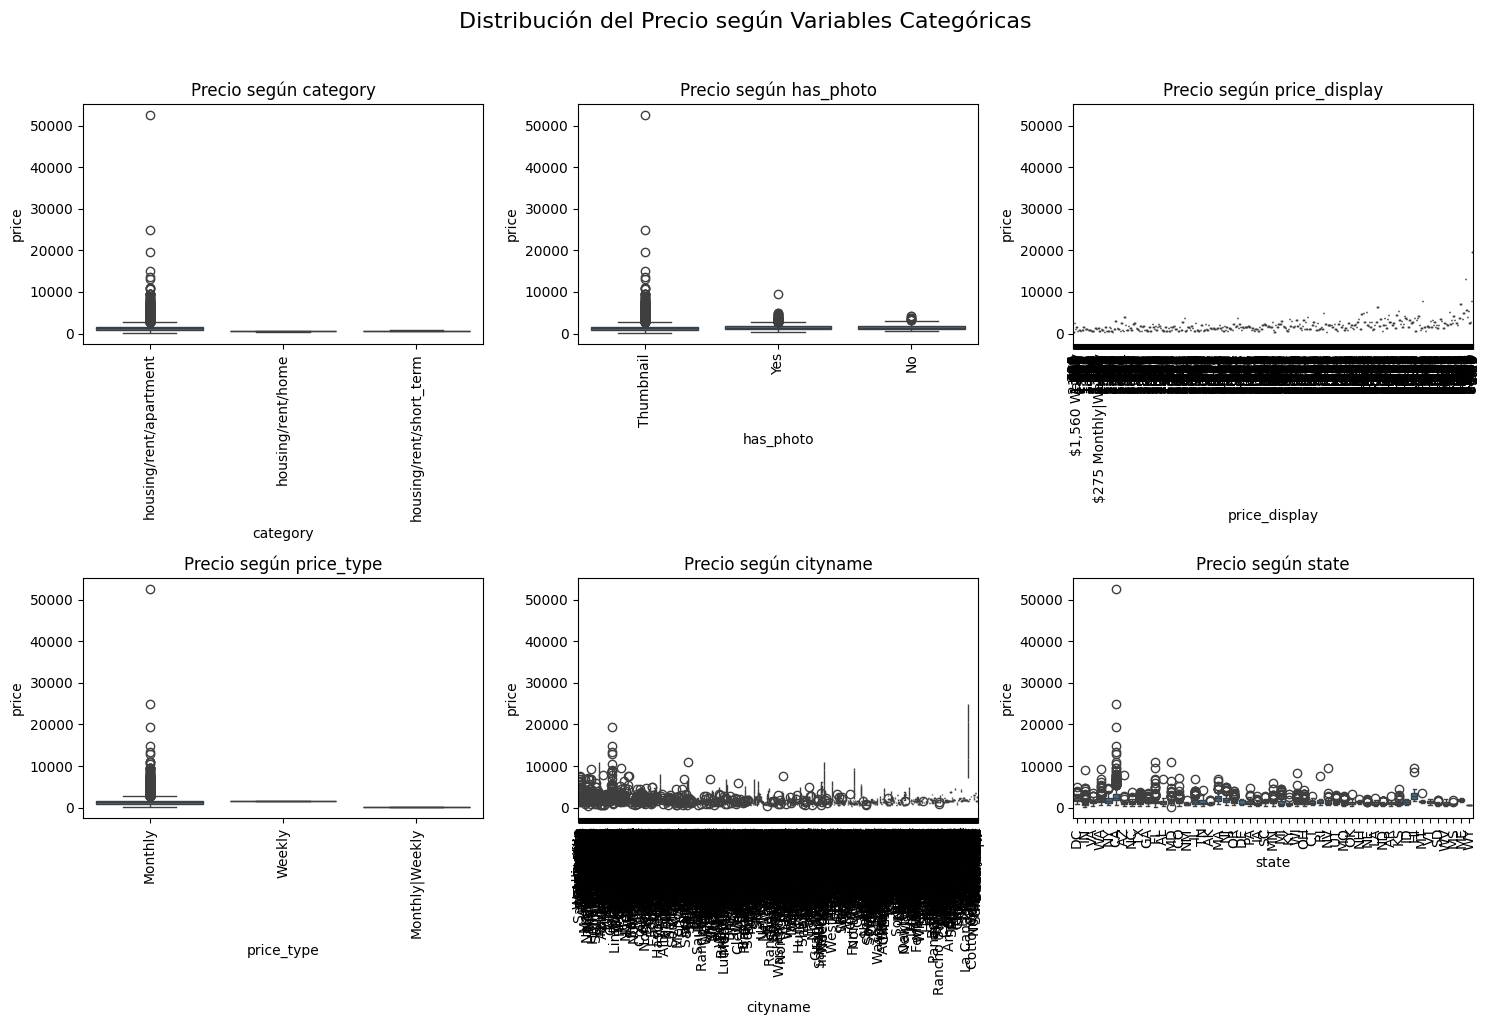

In [ ]:
def mi_boxplot_grid(df, categorical_columns, target_col="price", figsize=(15, 10), nrows=2, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle("Distribución del Precio según Variables Categóricas", fontsize=16, y=1.02)

    axes = axes.flatten()

    for i, col in enumerate(categorical_columns):
        sns.boxplot(x=col, y=target_col, data=df, ax=axes[i])
        axes[i].set_title(f"Precio según {col}")
        axes[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

mi_boxplot_grid(df, Variables_NoNum, nrows=2, ncols=3)

Los Boxplots del preció según los valores de las variables categóricas dan indicios como:
* _State_ debería tener integrada la información de _Cityname_, al menos a groso modo
* _Pricedisplay_ apesar de haber sido identificada como no numérica por pandas parece contener información numérica continua
    * Revisando los datos, _Pricedisplay_ almacena el mismo precio pero con un formato distinto. Es decir, no es una variable relevante pues no integra más información que la del precio y en ocasiones la del _Pricetype_

In [ ]:
Variables_NoNum.remove("price_display")
Variables_NoNum.remove("cityname")

## Modelo de regresión
Habiendo explorado los datos y comprendido las correlaciones se puede ahora realizar aproximaciones al modelo

In [48]:
Variables_explicativas = Variables_NoNum + Variables_Num
#Variables_explicativas.remove("price")
print(Variables_explicativas)

['category', 'has_photo', 'price_type', 'state', 'bathrooms', 'bedrooms', 'price', 'square_feet']


La primer propuesta de modelo sería: 

$y = \beta_0 + \beta_1 \times \text{bathrooms} + \beta_2 \times \text{bedrooms} + \beta_3 \times \text{square\_feet} + \beta_4 \times \text{category} + \beta_5 \times \text{has\_photo} + \beta_6 \times \text{price\_type} + \beta_7 \times \text{state}$

Como varias variables no numéricas elegidas para el modelo son categóricas, para poder integrarlas se hace necesario el uso de dummies

In [50]:
df_modelo = df[Variables_explicativas]
df_modelo = pd.get_dummies(df_modelo, columns=Variables_NoNum, drop_first=True)
df_modelo.head()


,bathrooms,bedrooms,price,square_feet,category_housing/rent/home,category_housing/rent/short_term,has_photo_Thumbnail,has_photo_Yes,price_type_Monthly|Weekly,price_type_Weekly,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1.0,0.0,790,101,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1.0,425,106,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,0.0,1390,107,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1.0,0.0,925,116,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,1.0,0.0,880,125,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [71]:
print((df_modelo.columns))

Index(['bathrooms', 'bedrooms', 'price', 'square_feet',
       'category_housing/rent/home', 'category_housing/rent/short_term',
       'has_photo_Thumbnail', 'has_photo_Yes', 'price_type_Monthly|Weekly',
       'price_type_Weekly', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA',
       'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
       'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
       'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
       'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
       'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
       'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='object')


In [57]:
features = ['bathrooms', 'bedrooms', 'square_feet',
       'category_housing/rent/home', 'category_housing/rent/short_term',
       'has_photo_Thumbnail', 'has_photo_Yes', 'price_type_Monthly|Weekly',
       'price_type_Weekly', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL', 'state_GA',
       'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
       'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
       'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
       'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
       'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
       'state_WA', 'state_WI', 'state_WV', 'state_WY']
X = df_modelo[features]
Y = df_modelo['price'] 

### Entrenamiento del modelo

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

print(f"Dimensiones X de entrenamiento {X_train.shape}\nDimensiones X de test {X_test.shape}\nDimensiones Y de entrenamiento {Y_train.shape}\nDimensiones Y de test {Y_test.shape}")

Dimensiones X de entrenamiento (7437, 59)
Dimensiones X de test (2480, 59)
Dimensiones Y de entrenamiento (7437,)
Dimensiones Y de test (2480,)


In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

Y_pred = linreg.predict(X_test)

print(f"Intercepto: {linreg.intercept_:.4f}")
print("Coeficientes:")
for feature, coef in zip(features, linreg.coef_):
    print(f"  {feature}: {coef:.4f}")

Intercepto: 236.9343
Coeficientes:
  bathrooms: 203.7656
  bedrooms: -90.2765
  square_feet: 0.9260
  category_housing/rent/home: -270.5596
  category_housing/rent/short_term: -682.4264
  has_photo_Thumbnail: 11.7580
  has_photo_Yes: -61.9625
  price_type_Monthly|Weekly: -442.6492
  price_type_Weekly: 1260.1214
  state_AL: -368.3062
  state_AR: -550.2220
  state_AZ: -42.8487
  state_CA: 1567.2822
  state_CO: 246.7481
  state_CT: 229.2568
  state_DC: 1104.4602
  state_DE: -60.6959
  state_FL: 167.9547
  state_GA: -143.0448
  state_HI: 1615.8438
  state_IA: -248.8637
  state_ID: 108.5312
  state_IL: 322.8766
  state_IN: -85.4476
  state_KS: -306.8340
  state_KY: -225.1854
  state_LA: -269.7994
  state_MA: 1097.0400
  state_MD: 346.7327
  state_ME: 729.8604
  state_MI: 2.9833
  state_MN: 239.4362
  state_MO: -153.4131
  state_MS: -371.4600
  state_MT: -25.4565
  state_NC: -247.4959
  state_ND: -364.5313
  state_NE: -221.7172
  state_NH: 291.8638
  state_NJ: 792.7023
  state_NM: -14.3771
 

### Evaluación del modelo

**Error absoluto medio**: 

$$\text{MAE} = \frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Error cuadrado medio**: 
$$\text{MSE} = \frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Raíz del Error cuadrado medio**: 
$$\text{RMSE} = \sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [67]:
from sklearn import metrics

MAE = metrics.mean_absolute_error(Y_test, Y_pred)
MSE = metrics.mean_squared_error(Y_test, Y_pred)
RMSE = np.sqrt(MSE)

print(f"Mean Absolute Error (MAE): {MAE:.4f}")
print(f"Mean Squared Error (MSE): {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")

Mean Absolute Error (MAE): 373.0750
Mean Squared Error (MSE): 786921.0288
Root Mean Squared Error (RMSE): 887.0857


In [69]:
X_train.dtypes

const                               float64
bathrooms                           float64
bedrooms                            float64
square_feet                           int64
category_housing/rent/home             bool
category_housing/rent/short_term       bool
has_photo_Thumbnail                    bool
has_photo_Yes                          bool
price_type_Monthly|Weekly              bool
price_type_Weekly                      bool
state_AL                               bool
state_AR                               bool
state_AZ                               bool
state_CA                               bool
state_CO                               bool
state_CT                               bool
state_DC                               bool
state_DE                               bool
state_FL                               bool
state_GA                               bool
state_HI                               bool
state_IA                               bool
state_ID                        